In [14]:
#Import Libraries
from __future__ import print_function, division
import argparse
import os
import time
import utils
import torch
import torchvision
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchvision import transforms
from scipy.io import loadmat
from PIL import Image
import random
import torch.nn.functional as F
from torch.optim import lr_scheduler
import copy

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

seed = 25
np.random.seed(seed)
torch.manual_seed(seed)

#using GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [15]:
class car_dataset(Dataset):
    """
    Description:
        Pytorch Dataset class for reading Car Dataset meta files and images.
    Arguments:
        files (list, required): 
        root_dir (str, required): Root directory path
        meta_data (list, required): exctracted meta data
    Returns a Dictionary
    """
    def __init__(self, files, root_dir, meta_data, image_transform=None):
        
        self.root_dir = root_dir
        self.image_transform = image_transform
        
        #image file names
        self.image_files = [file[-1][0] for file in files]
        
        #Class ID
        self.id = [file[-2][0] - 1 for file in files]
        
        #Class Name
        self.class_name = [meta_data[file[-2][0] - 1][0] for file in files]
        
        #Get Car Year
        self.carYear, self.carYear_ID = utils.get_Year(self.class_name)

        #Get Car Maker
        self.carMaker, self.carMaker_ID = utils.get_Maker(self.class_name)
        
        #Get Car Type
        self.carType, self.carType_ID = utils.get_Type(self.class_name)
        
        #change and Move there is still time
        self.year_count = len(np.unique(self.carYear_ID))
        self.maker_count = len(np.unique(self.carMaker_ID))
        self.type_count = len(np.unique(self.carType_ID))
        
    def __len__(self):
        return len(self.id)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        img = Image.open(img_path)
        
        if self.image_transform:
            img = self.image_transform(img)
        
        target = torch.from_numpy(np.array(self.id[idx]))[0]
        
        class_count = {
                      "year": self.year_count,
                      "maker": self.maker_count,
                      "type": self.type_count
                     }

        sample = {'Image':img, 'class_ID':target, "class_name":self.class_name[idx],
                 'year_ID':self.carYear_ID[idx], 'maker_ID':self.carMaker_ID[idx],
                 'type_ID':self.carType_ID[idx], "class_count":class_count}
        
        return sample

In [16]:
class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset creating
        a weight depeding of the frequency of the class
    Arguments:
        dataset (list, optional): a list of indices
        class_type (int, optional): 
    """
    def __init__(self, dataset, class_type):
                      
        self.indices = list(range(len(dataset)))
        
        self.num_samples = len(self.indices) 
        # distribution of classes in the dataset 
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx, class_type)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx, class_type)] for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx, class_type):
        return dataset[idx][class_type].item()
                
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
                self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples

In [17]:
root_dir = "data/cars_train/"
car_annotations_path = "data/devkit/cars_train_annos.mat"
car_metadata_path = "data/devkit/cars_meta.mat"

#Load Meta Data
meta_data = loadmat(car_metadata_path)
meta_data = np.concatenate(meta_data["class_names"][0])

#nb_classes
nb_classes = len(meta_data)

#Load and split train, val and test samples
dataset = utils.Load_Images(root_dir=root_dir, annotations_path=car_annotations_path, seed=seed, test_split=0.2)

In [18]:
image_transformers = {'training': transforms.Compose([transforms.Resize((224, 224)),
                                                       transforms.RandomRotation(degrees=50),
                                                       transforms.RandomHorizontalFlip(0.8),
                                                       transforms.RandomPerspective(p=0.1),
                                                     transforms.ColorJitter(brightness=0.8, contrast=0.8),
                                                     transforms.ToTensor()]),
                      'validation': transforms.Compose([transforms.Resize((224, 224)),
                                                       transforms.ToTensor()])
                     }
    

training_data = car_dataset(dataset["training"],
                            root_dir = root_dir,
                            meta_data = meta_data,
                            image_transform = image_transformers["training"]
                           )

#
train_loader = torch.utils.data.DataLoader(training_data, batch_size=15, 
                                           sampler=ImbalancedDatasetSampler(training_data, "class_ID"))

#train_loader = torch.utils.data.DataLoader(training_data, batch_size=15, shuffle=True)

validation_data = car_dataset(dataset["validation"], 
                             root_dir = root_dir,
                             meta_data = meta_data,
                             image_transform  = image_transformers["validation"])

validation_loader = torch.utils.data.DataLoader(validation_data, 
                                                batch_size=15, shuffle=True)

'''
testing_data = car_dataset(dataset["test"], 
                           root_dir = root_dir,
                           meta_data = meta_data,
                           image_transform  = image_transformers["validation"])

test_loader = torch.utils.data.DataLoader(testing_data, batch_size=15, shuffle=True)
'''

dataloaders = {"training":train_loader, "validation":validation_loader}
dataSizes = {"training":len(dataset["training"]), "validation":len(dataset["validation"])}

In [19]:
#Get Count per each Class
class_year = training_data[0]["class_count"]["year"]
class_maker = training_data[0]["class_count"]["maker"]
class_type = training_data[0]["class_count"]["type"]

In [20]:
#Load Pretrained Model
fr_model = torchvision.models.resnet50(pretrained=True)

#freeze layers
for param in fr_model.parameters():
    param.requires_grad = False
    
print(fr_model)
num_ftrs = fr_model.fc.in_features
fr_model.fc = torch.nn.Linear(num_ftrs, 1024)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [21]:
class multi_task_model(torch.nn.Module):
    def __init__(self, base_model,nb_maker_classes, nb_type_classes):
        super(multi_task_model, self).__init__()
        
        self.base_model = base_model
        
        self.x1 = torch.nn.Linear(1024, 512)
        torch.nn.init.xavier_normal_(self.x1.weight) 
        self.bn1 = torch.nn.BatchNorm1d(512, eps = 2e-1)
        
        
        #could overfit add, dropout??
        self.x2 = torch.nn.Linear(512,512)
        torch.nn.init.xavier_normal_(self.x2.weight)
        self.bn2 = torch.nn.BatchNorm1d(512, eps = 2e-1)
        
        #adding one more on top of the heads
        self.x3 = torch.nn.Linear(512, 256)
        torch.nn.init.xavier_normal_(self.x3.weight)
        
        #Connect the base Model to each head
        self.y_maker = torch.nn.Linear(256, nb_maker_classes)
        torch.nn.init.xavier_normal_(self.y_maker.weight)
        self.y_type = torch.nn.Linear(256, nb_type_classes)
        torch.nn.init.xavier_normal_(self.y_type.weight)
        
    def forward(self, x):
        
        x1 = self.base_model(x)
        
        x1 = self.bn1(F.relu(self.x1(x1)))
        x1 = self.bn2(F.relu(self.x2(x1)))
        
        y_maker_output = F.softmax(self.y_maker(self.x3(x1)))
        y_type_output = F.softmax(self.y_type(self.x3(x1)))
        
        return y_maker_output, y_type_output

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
MTL_model = multi_task_model(fr_model, class_maker, class_type)
MTL_model = MTL_model.to(device)

print(MTL_model)
print(MTL_model.parameters())   

criterion = torch.nn.CrossEntropyLoss() 

multi_task_model(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
        

In [23]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    #last recorded best loss
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 30)

        # Each epoch has a training and validation phase
        for phase in ['training', 'validation']:
            if phase == 'training':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            year_loss = 0.0
            type_loss = 0.0
            maker_loss = 0.0

            correct_year = 0.0
            correct_maker = 0.0
            correct_type = 0.0
            
            # Iterate over data.
            for batch_idx, data in enumerate(dataloaders[phase]):
                
                inputs = data["Image"].to(device)
                
                maker_labels = data["maker_ID"].to(device)
                type_labels = data["type_ID"].to(device)
            
                optimizer.zero_grad()
                
                #set to true when training
                with torch.set_grad_enabled(phase == 'training'):
                    outputs = model(inputs)
                    
                    #Order: maker, type
                    loss_maker = criterion(outputs[0], maker_labels.long())
                    loss_type = criterion(outputs[1], type_labels.long())
                    
                    if phase == 'training':
                        
                        #take sum of all loses
                        total_loss = loss_maker + loss_type
                        
                        total_loss.backward()
                        optimizer.step()
                        
                running_loss += total_loss.item() * inputs.size(0)
                
                type_loss += loss_maker.item() * inputs.size(0)
                maker_loss += loss_type.item() * inputs.size(0)    
                
                correct_counts_maker = torch.max(outputs[0], dim=1)[1].eq(maker_labels.data.view_as(torch.max(outputs[0], dim=1)[1]))
                correct_counts_type = torch.max(outputs[1], dim=1)[1].eq(type_labels.data.view_as(torch.max(outputs[1], dim=1)[1]))
                
                acc_m = torch.mean(correct_counts_maker.type(torch.FloatTensor))
                acc_t = torch.mean(correct_counts_type.type(torch.FloatTensor))
                
                correct_maker += acc_m.item() * inputs.size(0)
                correct_type += acc_t.item() * inputs.size(0)
                

                      
            step_loss = running_loss / dataSizes[phase]
            
            maker_loss_total = maker_loss / dataSizes[phase]
            type_loss_total = type_loss / dataSizes[phase]

            maker_acc = correct_maker / dataSizes[phase]
            type_acc = correct_type / dataSizes[phase]
            
            print('{} total loss: {:.4f}'.format(phase, step_loss))
            print('{} Maker_acc: {:.2f}  Type_acc: {:.2f}'.format(phase, maker_acc, type_acc))
            print('{} Maker_loss: {:.2f}  Type_loss: {:.2f}'.format(phase,maker_loss_total,type_loss_total))
            history.append([epoch, step_loss, maker_loss_total, type_loss_total, maker_acc, type_acc])
            
            # deep copy the model depending on best accuracy of Car Maker
            
            if phase == 'validation' and maker_acc > best_val_acc:
                print('saving with acc of {}'.format(maker_acc))
                best_val_acc = maker_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(float(best_acc)))

    # load best model weights
    last_model_weights = copy.deepcopy(model.state_dict())
    model.load_state_dict(best_model_wts)
    return model, last_model_weights, history

In [24]:

lrlast = .001 #learning rate for heads
lrmain = .0001

optimizers = torch.optim.Adam(
    [
        {"params":MTL_model.base_model.parameters(),"lr": lrmain},
        {"params":MTL_model.x1.parameters(), "lr": lrlast},
        {"params":MTL_model.x2.parameters(), "lr": lrlast},
        {"params":MTL_model.y_maker.parameters(), "lr": lrlast},
        {"params":MTL_model.y_type.parameters(), "lr": lrlast}  
   ])

#optim1 = optim.Adam(model_1.parameters(), lr=0.0001)#,momentum=.9)
# Observe that all parameters are being optimized
optimizer_ft = optimizers

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
#my last
trained_model, l_model, history = train_model(MTL_model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50)

Epoch 0/49
------------------------------


C:\Users\ryan_\.conda\envs\azure_grabchallenge\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\ryan_\.conda\envs\azure_grabchallenge\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


training total loss: 6.1675
training Maker_acc: 0.10  Type_acc: 0.28
training Maker_loss: 2.33  Type_loss: 3.84
validation total loss: 6.4360
validation Maker_acc: 0.13  Type_acc: 0.38
validation Maker_loss: 2.24  Type_loss: 3.80
saving with acc of 0.12879409826833563
Epoch 1/49
------------------------------
training total loss: 6.0942
training Maker_acc: 0.13  Type_acc: 0.32
training Maker_loss: 2.30  Type_loss: 3.80
validation total loss: 6.3376
validation Maker_acc: 0.15  Type_acc: 0.42
validation Maker_loss: 2.20  Type_loss: 3.78
saving with acc of 0.1509434028151976
Epoch 2/49
------------------------------
training total loss: 6.0499
training Maker_acc: 0.14  Type_acc: 0.35
training Maker_loss: 2.26  Type_loss: 3.79
validation total loss: 5.5544
validation Maker_acc: 0.14  Type_acc: 0.45
validation Maker_loss: 2.17  Type_loss: 3.78
Epoch 3/49
------------------------------
training total loss: 6.0327
training Maker_acc: 0.15  Type_acc: 0.36
training Maker_loss: 2.25  Type_loss: 

training total loss: 5.9631
training Maker_acc: 0.18  Type_acc: 0.40
training Maker_loss: 2.21  Type_loss: 3.75
validation total loss: 5.9581
validation Maker_acc: 0.19  Type_acc: 0.52
validation Maker_loss: 2.10  Type_loss: 3.74
Epoch 30/49
------------------------------
training total loss: 5.9676
training Maker_acc: 0.17  Type_acc: 0.41
training Maker_loss: 2.21  Type_loss: 3.76
validation total loss: 6.1319
validation Maker_acc: 0.19  Type_acc: 0.49
validation Maker_loss: 2.12  Type_loss: 3.74
Epoch 31/49
------------------------------
training total loss: 5.9577
training Maker_acc: 0.18  Type_acc: 0.41
training Maker_loss: 2.21  Type_loss: 3.75
validation total loss: 6.3505
validation Maker_acc: 0.19  Type_acc: 0.50
validation Maker_loss: 2.12  Type_loss: 3.74
Epoch 32/49
------------------------------
training total loss: 5.9673
training Maker_acc: 0.17  Type_acc: 0.41
training Maker_loss: 2.21  Type_loss: 3.76
validation total loss: 5.8332
validation Maker_acc: 0.18  Type_acc: 0

In [12]:
trained_model, history = train_model(MTL_model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 0/29
------------------------------


C:\Users\ryan_\.conda\envs\azure_grabchallenge\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\ryan_\.conda\envs\azure_grabchallenge\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


training total loss: 5.8508
training Maker_acc: 0.28  Type_acc: 0.41
training Maker_loss: 2.2049  Type_loss: 3.6459
validation total loss: 5.7882
validation Maker_acc: 0.08  Type_acc: 0.27
validation Maker_loss: 2.3422  Type_loss: 3.8446
saving with loss of 5.788242816925049 improved over previous 150
Epoch 1/29
------------------------------
training total loss: 5.6737
training Maker_acc: 0.36  Type_acc: 0.50
training Maker_loss: 2.1113  Type_loss: 3.5624
validation total loss: 5.6764
validation Maker_acc: 0.09  Type_acc: 0.28
validation Maker_loss: 2.3366  Type_loss: 3.8387
saving with loss of 5.676398754119873 improved over previous 5.788242816925049
Epoch 2/29
------------------------------
training total loss: 5.6232
training Maker_acc: 0.39  Type_acc: 0.53
training Maker_loss: 2.0824  Type_loss: 3.5408
validation total loss: 5.8670
validation Maker_acc: 0.09  Type_acc: 0.34
validation Maker_loss: 2.2773  Type_loss: 3.8387
Epoch 3/29
------------------------------
training total l

validation total loss: 5.9631
validation Maker_acc: 0.12  Type_acc: 0.41
validation Maker_loss: 2.2078  Type_loss: 3.8101
Epoch 29/29
------------------------------
training total loss: 5.4933
training Maker_acc: 0.44  Type_acc: 0.61
training Maker_loss: 2.0083  Type_loss: 3.4850
validation total loss: 5.6345
validation Maker_acc: 0.11  Type_acc: 0.42
validation Maker_loss: 2.1993  Type_loss: 3.8103
Training complete in 75m 23s
Best val Acc: 4.955569


In [13]:
#save them weights
torch.save(trained_model.state_dict(), 'MTL_weights_1.pth')

In [14]:

fr_model = torchvision.models.resnet50(pretrained=True)

#Load Model weights
for param in fr_model.parameters():
    param.requires_grad = False

num_ftrs = fr_model.fc.in_features
fr_model.fc = torch.nn.Linear(num_ftrs, 1024)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
MTL_model = multi_task_model(fr_model, class_maker, class_type)
MTL_model = MTL_model.to(device)

MTL_model.load_state_dict(torch.load('MTL_weights_1.pth'))
MTL_model.eval()

multi_task_model(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
        

In [32]:
car_types = ["Coupe", "Sedan", "Cab",
             "Beetle", "SUV", "Van",
             "SuperCab", "Convertible",
             "Minivan", "Hatchback",
             "Wagon", "no_type"]

makers = ["AM General Hummer", "Acura", "Aston Martin", "Audi" , "BMW", "Bentley", "Bugatti Veyron 16.4","Buick","Cadillac",
         "Chevrolet", "Chrysler", "Daewoo", "Dodge", "Eagle Talon", "FIAT", "Ferrari", "Ford", "GMC", "Geo Metro Convertible", 
         "HUMMER", "Honda", "Hyundai", "Infiniti", "Isuzu Ascender", "Jaguar", "Jeep", "Lamborghini", "Land Rover", 
         "Lincoln Town Car", "MINI Cooper Roadster", "Maybach Landaulet", "Mazda Tribute", "McLaren MP4-12C", "Mercedes-Benz", 
         "Mitsubishi Lancer","Nissan", "Plymouth Neon", "Porsche Panamera", "Ram C/V", "Rolls-Royce", "Scion", "Spyker", "Suzuki", 
         "Tesla", "Toyota", "Volkswagen", "Volvo", "smart fortwo", "Fisker Karma Sedan"]

def extract_label(label_list, pred_array, top_n=1):
    pred_max = torch.topk(pred_array,top_n)[1]    
    out_list = []
    for i in pred_max[0]:
        out_list.append(label_list[i])
    return out_list



['Bentley', 'Nissan', 'Bugatti Veyron 16.4', 'Scion', 'Eagle Talon']
['Convertible', 'SUV', 'Beetle', 'Van', 'Coupe']
Classified Maker: ['Bentley'], Classified Type: ['Convertible']


C:\Users\ryan_\.conda\envs\azure_grabchallenge\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\ryan_\.conda\envs\azure_grabchallenge\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


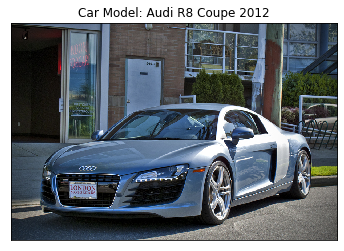

['FIAT', 'Toyota', 'Bentley', 'Nissan', 'Bugatti Veyron 16.4']
['Convertible', 'no_type', 'SUV', 'Cab', 'Wagon']
Classified Maker: ['FIAT'], Classified Type: ['Convertible']


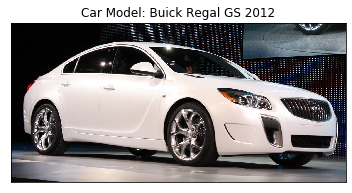

['Porsche Panamera', 'Jeep', 'Eagle Talon', 'Ford', 'Bentley']
['Convertible', 'no_type', 'SUV', 'Beetle', 'Wagon']
Classified Maker: ['Porsche Panamera'], Classified Type: ['Convertible']


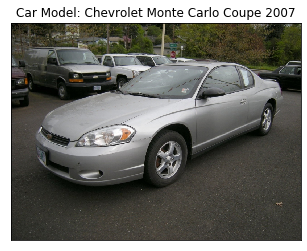

['Toyota', 'Ford', 'Bugatti Veyron 16.4', 'Porsche Panamera', 'Mazda Tribute']
['Convertible', 'Beetle', 'no_type', 'Wagon', 'Cab']
Classified Maker: ['Toyota'], Classified Type: ['Convertible']


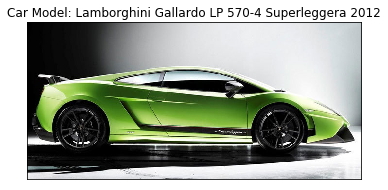

['Spyker', 'FIAT', 'Nissan', 'Eagle Talon', 'Porsche Panamera']
['SUV', 'Convertible', 'Wagon', 'Beetle', 'SuperCab']
Classified Maker: ['Spyker'], Classified Type: ['SUV']


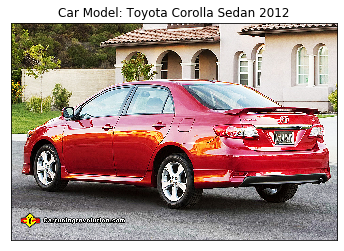

['Geo Metro Convertible', 'HUMMER', 'Honda', 'AM General Hummer', 'Ferrari']
['Sedan', 'Hatchback', 'SuperCab', 'SUV', 'Van']
Classified Maker: ['Geo Metro Convertible'], Classified Type: ['Sedan']


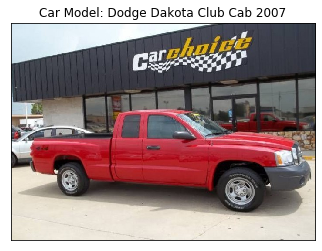

['Lincoln Town Car', 'Jaguar', 'Spyker', 'Fisker Karma Sedan', 'McLaren MP4-12C']
['SuperCab', 'Hatchback', 'SUV', 'Sedan', 'Cab']
Classified Maker: ['Lincoln Town Car'], Classified Type: ['SuperCab']


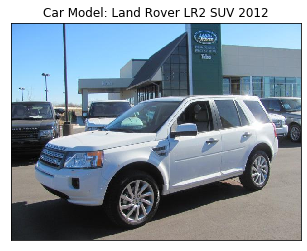

['Ferrari', 'Mercedes-Benz', 'Land Rover', 'HUMMER', 'Suzuki']
['Beetle', 'Cab', 'SUV', 'Hatchback', 'Minivan']
Classified Maker: ['Ferrari'], Classified Type: ['Beetle']


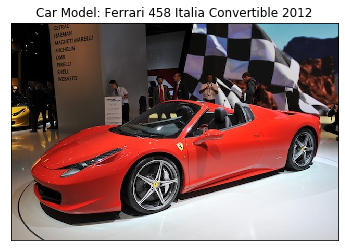

['FIAT', 'Porsche Panamera', 'Fisker Karma Sedan', 'Toyota', 'Tesla']
['SUV', 'Wagon', 'Convertible', 'no_type', 'Cab']
Classified Maker: ['FIAT'], Classified Type: ['SUV']


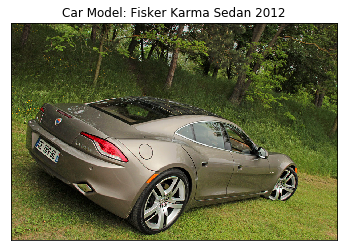

['Jaguar', 'Rolls-Royce', 'Geo Metro Convertible', 'Cadillac', 'MINI Cooper Roadster']
['SuperCab', 'Hatchback', 'Sedan', 'Van', 'Coupe']
Classified Maker: ['Jaguar'], Classified Type: ['SuperCab']


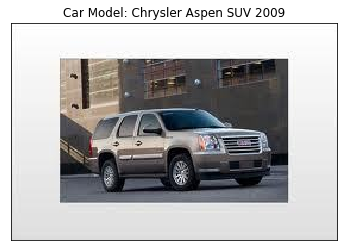

In [27]:
#Sanity check
#Classify a few images in the testset

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = image_transformers["validation"](image).float()
    image = Variable(image, requires_grad=False)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image.cuda()  #assumes that you're using GPU

for image_file in dataset["test"][20:30]:
    file_path = os.path.join(root_dir,image_file[-1][0])
    img = image_loader(file_path)
    
    output = MTL_model(img)
    print("Classified Maker: {}, Classified Type: {}".format(extract_label(makers, output[0]), 
                                                            extract_label(car_types, output[1])))
    pil_im = Image.open(file_path)
    plt.imshow(np.asarray(pil_im))
    plt.title("Car Model: {}".format(meta_data[image_file[-2][0][0]-1]))
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

In [34]:
#get labels of testing set
y_labels = [meta_data[label[-2][0][0]-1] for label in  dataset["test"]]
y_type_labels = utils.get_Type(y_labels)
y_maker_labels = utils.get_Maker(y_labels)

#get classification
yhat_type = []
yhat_maker = []
for image_file in dataset["test"]:
    file_path = os.path.join(root_dir,image_file[-1][0])
    img = image_loader(file_path)
    
    output = MTL_model(img)
    yhat_maker.append(extract_label(makers, output[0])[0])
    yhat_type.append(extract_label(car_types, output[1])[0])

C:\Users\ryan_\.conda\envs\azure_grabchallenge\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\ryan_\.conda\envs\azure_grabchallenge\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


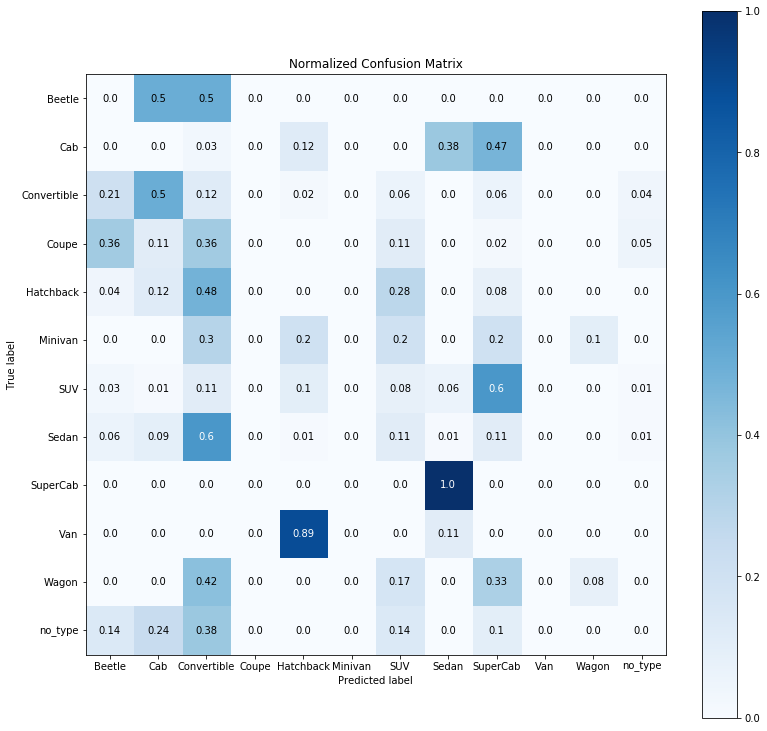

In [42]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_type_labels[0], yhat_type, normalize=True,figsize=(13,13))

In [ ]:
>>> import matplotlib.pyplot as plt
>>> import scikitplot as skplt
>>> # This is a Keras classifier. We'll generate probabilities on the test set.
>>> keras_clf.fit(X_train, y_train, batch_size=64, nb_epoch=10, verbose=2)
>>> probas = keras_clf.predict_proba(X_test, batch_size=64)
>>> # Now plot.
>>> skplt.metrics.plot_precision_recall_curve(y_test, probas)
<matplotlib.axes._subplots.AxesSubplot object at 0x7fe967d64490>
>

In [ ]:
def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = image_transformers["validation"](image).float()
    image = Variable(image, requires_grad=False)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image.cuda()  #assumes that you're using GPU

for image_file in dataset["test"][:10]:
    
    #file location
    file_path = os.path.join(root_dir,image_file[-1][0])
    img = image_loader(file_path)
    
    output = MTL_model(img)
    print(extract_label(makers,  output[0]), extract_label(car_types,  output[1]))
    print(meta_data[image_file[-2][0][0]-1])
    
    pil_im = Image.open(file_loc)
    plt.imshow(np.asarray(pil_im))
    plt.la
    plt.show()

(['Convertible',
  'SUV',
  'Convertible',
  'no_type',
  'Coupe',
  'Sedan',
  'Cab',
  'Cab',
  'Van',
  'Sedan',
  'Cab',
  'Coupe',
  'Cab',
  'Sedan',
  'Wagon',
  'Hatchback',
  'no_type',
  'SUV',
  'Coupe',
  'Sedan',
  'Coupe',
  'no_type',
  'Coupe',
  'no_type',
  'Sedan',
  'Cab',
  'SUV',
  'Convertible',
  'Sedan',
  'SUV',
  'Van',
  'Cab',
  'Convertible',
  'Hatchback',
  'Convertible',
  'Cab',
  'Convertible',
  'Sedan',
  'Sedan',
  'no_type',
  'Coupe',
  'Coupe',
  'Convertible',
  'Sedan',
  'Convertible',
  'Sedan',
  'Wagon',
  'Coupe',
  'Van',
  'Convertible',
  'Sedan',
  'no_type',
  'Cab',
  'Convertible',
  'Sedan',
  'Sedan',
  'no_type',
  'Sedan',
  'Wagon',
  'SUV',
  'Minivan',
  'Hatchback',
  'Hatchback',
  'SUV',
  'Coupe',
  'Hatchback',
  'Van',
  'Sedan',
  'Sedan',
  'SUV',
  'Hatchback',
  'SUV',
  'Convertible',
  'Sedan',
  'SUV',
  'Convertible',
  'Sedan',
  'Sedan',
  'SUV',
  'SUV',
  'Convertible',
  'Coupe',
  'Coupe',
  'no_type',
  

In [ ]:
#get accuracy (maker, model), #get ROC curve

#fuzzy logic for some exact matching

In [13]:
#evaluation mode
from os import listdir
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

from torch.autograd import Variable
def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = image_transformers["validation"](image).float()
    image = Variable(image, requires_grad=False)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image.cuda()  #assumes that you're using GPU

for image_file in dataset["test"][:10]:
    file_loc = os.path.join(root_dir,image_file[-1][0])
    img = image_loader(file_loc)
    
    d = MTL_model(img)
    print(extract_label(makers, d[0]), extract_label(car_types, d[1]))
    print(meta_data[image_file[-2][0][0]-1])
    
    pil_im = Image.open(file_loc)
    plt.imshow(np.asarray(pil_im))
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

C:\Users\ryan_\.conda\envs\azure_grabchallenge\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
C:\Users\ryan_\.conda\envs\azure_grabchallenge\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


NameError: name 'extract_label' is not defined

In [16]:
Values = []
targets = []
for batch_idx, data in enumerate(testing):

    targets.append([data["maker_ID"].to(device),
                    data["type_ID"].to(device)])

    if batch_idx > 10:
        break

KeyError: 'test'

In [ ]:
from torch.autograd import Variable

imsize = 224
loader = transforms.Compose([transforms.Resize((imsize,imsize)),
                             transforms.ToTensor(),
                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

#image test folder
folder_path = ""


#saber4.png

image = image_loader('jalter3.jpg')
y_pred = model1(image)

In [ ]:
import utils

In [ ]:
torch.cuda.empty_cache()

In [ ]:
dataset_test = utils.Load_Images(root_dir="testing_data/", annotations_path="data/devkit/cars_test_annos.mat",seed=10, train=False)

In [ ]:
len(meta_data)